# lib

In [2]:
import pickle
# import warnings
# warnings.filterwarnings('ignore')
# import os
# import pandas as pd
import numpy as np
# import math
# import datetime as dt
import matplotlib.pyplot as plt

# from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
# from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
# from sklearn.preprocessing import MinMaxScaler , StandardScaler

# from itertools import product
# import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, ConvLSTM1D, Conv1D, Concatenate, Bidirectional
from tensorflow.keras.layers import LSTM , BatchNormalization, AveragePooling1D, Flatten, GRU, SimpleRNN

# from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

plt.style.use('seaborn-darkgrid')

# creat data lstm

In [3]:
with open('btc_stan.moh','rb') as f :
    btc = pickle.load(f)
btc=(btc+2)/4


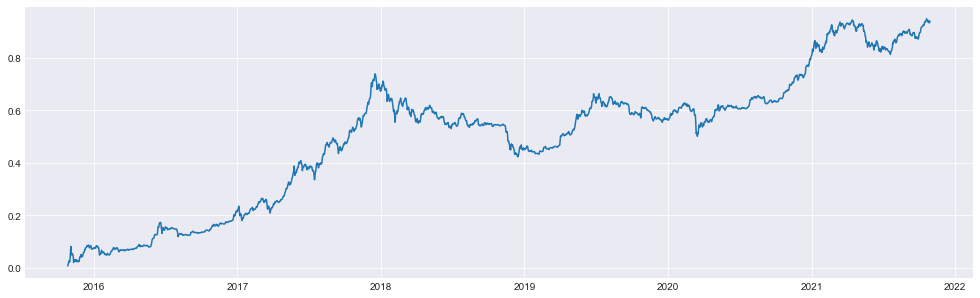

In [4]:
plt.figure(figsize=(17,5))
plt.plot(btc.close_log)

In [5]:
look_back_ = 90
prediction_days = 60
future_ = 30


df_train_= btc[:][:len(btc)-(prediction_days+future_)]#values.reshape(-1,1)

df_test_= btc[:][len(btc)-(prediction_days+future_+look_back_-1):len(btc)-future_]#.values.reshape(-1,1)

future_ = btc[:][len(btc)-(future_+look_back_-1):]

In [6]:
df_train_.columns

Index(['close_log', 'close', 'target_log', 'target'], dtype='object')

In [7]:
col = ['close_log', 'close', 'target_log', 'target']
df_train = df_train_[:][col]
df_test = df_test_[:][col]
future = future_[:][col]
df_test.head(2)

,close_log,close,target_log,target
date,,,,
2021-05-04,0.920746,1.239421,0.922647,1.247350
2021-05-05,0.922647,1.249706,0.925998,1.265423


In [8]:
# # many to one

# from collections import deque
# def dataset_generator_lstm(dataset, look_back=look_back_):
#   sequential_data = [] 
#   prev_days = deque(maxlen=look_back)
#   for i in dataset.values:
#     prev_days.append([n for n in i[:-1]])
#     if len(prev_days) == look_back:  
#       sequential_data.append([np.array(prev_days), i[-1]])
#   dataX=[]
#   dataY=[]
#   for seq, target in sequential_data: 
#     dataX.append(seq) 
#     dataY.append(target) 
#   return np.array(dataX), np.array(dataY)

# trainX, trainY = dataset_generator_lstm(df_train)

# testX, testY = dataset_generator_lstm(df_test)
# # trainX, trainY = trainX[:1740], trainY[:1740]

# futureX, futureY = dataset_generator_lstm(future)

# print("trainX: ", trainX.shape)
# print("trainY: ", trainY.shape)
# print("testX: ", testX.shape)
# print("testY", testY.shape)
# print("futureX: ", futureX.shape)
# print("futureY", futureY.shape)

In [9]:
# one to one

from collections import deque
def dataset_generator_lstm(dataset, look_back=look_back_):
    sequential_data = [] 
    sequential_data_log = [] 
    prev_days = deque(maxlen=look_back)
    prev_days_log = deque(maxlen=look_back)

    for i in dataset.values:
        prev_days_log.append(i[0])
        prev_days.append(i[1])

        if len(prev_days) == look_back:  
            sequential_data_log.append([np.array(prev_days), i[-1]])
            sequential_data.append([np.array(prev_days), i[-2]])
      
      
    dataX_log=[]
    dataY_log=[]

    dataX=[]
    dataY=[]

    for seq, target in sequential_data_log: 
        dataX_log.append(seq) 
        dataY_log.append(target) 

    for seq, target in sequential_data: 
        dataX.append(seq) 
        dataY.append(target) 

    dataX_log = tf.expand_dims(dataX_log,axis=2)
    dataX = tf.expand_dims(dataX,axis=2)

    return np.array(dataX_log), np.array(dataY_log), np.array(dataX), np.array(dataY)

trainX_log, trainY_log, trainX, trainY = dataset_generator_lstm(df_train)

testX_log, testY_log, testX, testY = dataset_generator_lstm(df_test)
# trainX, trainY = trainX[:1740], trainY[:1740]

futureX_log, futureY_log, futureX, futureY = dataset_generator_lstm(future)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("trainX_log: ", trainX_log.shape)
print("trainY_log: ", trainY_log.shape)
print("testX: ", testX.shape)
print("testY", testY.shape)
print("testX_log: ", testX_log.shape)
print("testY_log", testY_log.shape)
print("futureX: ", futureX.shape)
print("futureY", futureY.shape)
print("futureX_log: ", futureX_log.shape)
print("futureY_log", futureY_log.shape)

trainX:  (2016, 90, 1)
trainY:  (2016,)
trainX_log:  (2016, 90, 1)
trainY_log:  (2016,)
testX:  (60, 90, 1)
testY (60,)
testX_log:  (60, 90, 1)
testY_log (60,)
futureX:  (30, 90, 1)
futureY (30,)
futureX_log:  (30, 90, 1)
futureY_log (30,)


# train

In [10]:
input1 = Input(shape=trainX_log.shape[1:])

conv111 = Conv1D(filters=30,kernel_size=30,padding="same",activation="relu")(input1)
conv112 = Conv1D(filters=60,kernel_size=14,padding="same",activation="relu")(input1)
conv113 = Conv1D(filters=90,kernel_size=7,padding="same",activation="relu")(input1)

conv11 = Concatenate(axis=2)([conv111, conv112, conv113])

pool11 = AveragePooling1D(pool_size=61, strides=1, padding="valid", data_format="channels_last")(conv11)

norm11 = BatchNormalization()(pool11)
drop11 = Dropout(rate=0.3)(norm11)

conv121 = Conv1D(filters=90,kernel_size=21,padding="same",activation="relu")(drop11)
conv122 = Conv1D(filters=180,kernel_size=14,padding="same",activation="relu")(drop11)
conv123 = Conv1D(filters=270,kernel_size=7,padding="same",activation="relu")(drop11)

conv12 = Concatenate(axis=2)([conv121, conv122, conv123])

pool12 = AveragePooling1D(pool_size=16, strides=1, padding="valid", data_format="channels_last")(conv12)

norm12 = BatchNormalization()(pool12)
drop12 = Dropout(rate=0.3)(norm12)

conv131 = Conv1D(filters=270,kernel_size=21,padding="same",activation="relu")(drop12)
conv132 = Conv1D(filters=360,kernel_size=14,padding="same",activation="relu")(drop12)
conv133 = Conv1D(filters=450,kernel_size=7,padding="same",activation="relu")(drop12)

conv13 = Concatenate(axis=2)([conv131, conv132, conv133])

pool13 = AveragePooling1D(pool_size=9, strides=1, padding="valid", data_format="channels_last")(conv13)

norm13 = BatchNormalization()(pool13)
drop13 = Dropout(rate=0.3)(norm13)



conv211 = Conv1D(filters=30,kernel_size=30,padding="same",activation="relu")(input1)
conv212 = Conv1D(filters=60,kernel_size=14,padding="same",activation="relu")(input1)
conv213 = Conv1D(filters=90,kernel_size=7,padding="same",activation="relu")(input1)

conv21 = Concatenate(axis=2)([conv211, conv212, conv213])

pool21 = AveragePooling1D(pool_size=61, strides=1, padding="valid", data_format="channels_last")(conv21)

norm21 = BatchNormalization()(pool21)
drop21 = Dropout(rate=0.3)(norm21)

conv221 = Conv1D(filters=90,kernel_size=21,padding="same",activation="relu")(drop21)
conv222 = Conv1D(filters=180,kernel_size=14,padding="same",activation="relu")(drop21)
conv223 = Conv1D(filters=270,kernel_size=7,padding="same",activation="relu")(drop21)

conv22 = Concatenate(axis=2)([conv221, conv222, conv223])

pool22 = AveragePooling1D(pool_size=16, strides=1, padding="valid", data_format="channels_last")(conv22)

norm22 = BatchNormalization()(pool22)
drop22 = Dropout(rate=0.3)(norm22)

conv231 = Conv1D(filters=270,kernel_size=21,padding="same",activation="relu")(drop22)
conv232 = Conv1D(filters=360,kernel_size=14,padding="same",activation="relu")(drop22)
conv233 = Conv1D(filters=450,kernel_size=7,padding="same",activation="relu")(drop22)

conv23 = Concatenate(axis=2)([conv231, conv232, conv233])

pool23 = AveragePooling1D(pool_size=9, strides=1, padding="valid", data_format="channels_last")(conv23)

norm23 = BatchNormalization()(pool23)
drop23 = Dropout(rate=0.3)(norm23)

drop3 = Concatenate(axis=2)([drop13, drop23])



rnn11 = Bidirectional(layer=LSTM(units = 512, activation = 'relu', return_sequences=True))(drop3)

norm14 = BatchNormalization()(rnn11)
drop14 = Dropout(rate=0.3)(norm14)

rnn12 = Bidirectional(LSTM(units = 256, activation = 'relu', return_sequences=True))(drop14)

norm15 = BatchNormalization()(rnn12)
drop15 = Dropout(rate=0.3)(norm15)

rnn13 = Bidirectional(LSTM(units = 512, activation = 'relu', return_sequences=True))(drop15)

norm15_2 = BatchNormalization()(rnn13)
drop15_2 = Dropout(rate=0.2)(norm15_2)

rnn14 = Bidirectional(LSTM(units = 256, activation = 'relu', return_sequences=True))(drop15_2)

norm16 = BatchNormalization()(rnn14)
drop16 = Dropout(rate=0.2)(norm16)

rnn15 = Bidirectional(LSTM(units = 512, activation = 'relu', return_sequences=True))(drop16)

flatten = Flatten()(rnn15)
norm17 = BatchNormalization()(flatten)
drop17 = Dropout(rate=0.3)(norm17)



rnn21 = Bidirectional(layer=GRU(units = 512, activation = 'relu', return_sequences=True))(drop3)

norm24 = BatchNormalization()(rnn21)
drop24 = Dropout(rate=0.3)(norm24)

rnn22 = Bidirectional(GRU(units = 256, activation = 'relu', return_sequences=True))(drop24)

norm25 = BatchNormalization()(rnn22)
drop25 = Dropout(rate=0.3)(norm25)

rnn23 = Bidirectional(GRU(units = 512, activation = 'relu', return_sequences=True))(drop25)

norm25_2 = BatchNormalization()(rnn23)
drop25_2 = Dropout(rate=0.2)(norm25_2)

rnn24 = Bidirectional(GRU(units = 256, activation = 'relu', return_sequences=True))(drop25_2)

norm26 = BatchNormalization()(rnn24)
drop26 = Dropout(rate=0.2)(norm26)

rnn25 = Bidirectional(GRU(units = 512, activation = 'relu', return_sequences=True))(drop26)

flatten2 = Flatten()(rnn25)
norm27 = BatchNormalization()(flatten2)
drop27 = Dropout(rate=0.3)(norm27)



rnn31 = Bidirectional(layer=GRU(units = 512, activation = 'relu', return_sequences=True))(drop3)

norm34 = BatchNormalization()(rnn31)
drop34 = Dropout(rate=0.3)(norm34)

rnn32 = Bidirectional(GRU(units = 256, activation = 'relu', return_sequences=True))(drop34)

norm35 = BatchNormalization()(rnn32)
drop35 = Dropout(rate=0.3)(norm35)

rnn33 = Bidirectional(GRU(units = 512, activation = 'relu', return_sequences=True))(drop35)

norm35_2 = BatchNormalization()(rnn33)
drop35_2 = Dropout(rate=0.2)(norm35_2)

rnn34 = Bidirectional(GRU(units = 256, activation = 'relu', return_sequences=True))(drop35_2)

norm36 = BatchNormalization()(rnn34)
drop36 = Dropout(rate=0.2)(norm36)

rnn35 = Bidirectional(GRU(units = 512, activation = 'relu', return_sequences=True))(drop36)

flatten3 = Flatten()(rnn35)
norm37 = BatchNormalization()(flatten3)
drop37 = Dropout(rate=0.3)(norm37)




drop7 = Concatenate()([drop17, drop27, drop37])



dense11 = Dense(units = 2048, activation='relu')(drop7)

norm18 = BatchNormalization()(dense11)
drop18 = Dropout(rate=0.3)(norm18)

dense12 = Dense(units = 1024, activation='relu')(drop18)

norm19 = BatchNormalization()(dense12)
drop19 = Dropout(rate=0.2)(norm19)

dense113 = Dense(units = 512, activation='relu')(drop19)

norm110 = BatchNormalization()(dense113)
drop110 = Dropout(rate=0.2)(norm110)




dense21 = Dense(units = 2048, activation='relu')(drop7)

norm28 = BatchNormalization()(dense21)
drop28 = Dropout(rate=0.3)(norm28)

dense22 = Dense(units = 1024, activation='relu')(drop28)

norm29 = BatchNormalization()(dense22)
drop29 = Dropout(rate=0.2)(norm29)

dense213 = Dense(units = 512, activation='relu')(drop29)

norm210 = BatchNormalization()(dense213)
drop210 = Dropout(rate=0.2)(norm210)



dense31 = Dense(units = 2048, activation='relu')(drop7)

norm38 = BatchNormalization()(dense31)
drop38 = Dropout(rate=0.3)(norm38)

dense32 = Dense(units = 1024, activation='relu')(drop38)

norm39 = BatchNormalization()(dense32)
drop39 = Dropout(rate=0.2)(norm39)

dense313 = Dense(units = 512, activation='relu')(drop39)

norm310 = BatchNormalization()(dense313)
drop310 = Dropout(rate=0.2)(norm310)




drop81 = Concatenate()([drop110, drop210, drop310])



dense1 = Dense(units = 2048, activation='relu')(drop81)

norm8 = BatchNormalization()(dense1)
drop8 = Dropout(rate=0.3)(norm8)

dense2 = Dense(units = 1024, activation='relu')(drop8)

norm10 = BatchNormalization()(dense1)
drop10 = Dropout(rate=0.2)(norm10)

dense3 = Dense(units = 512, activation='relu')(drop10)

norm11 = BatchNormalization()(dense3)
drop11 = Dropout(rate=0.2)(norm11)


output = Dense(units = 1)(drop10)

model = Model(inputs=input1, outputs=drop11)

model.summary()

dot_img_file = 'V0.8.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 90, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 90, 30)       930         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 90, 60)       900         ['input_1[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 90, 90)       720         ['input_1[0][0]']                
                                                                                              

 conv1d_15 (Conv1D)             (None, 15, 270)      3062070     ['dropout_4[0][0]']              
                                                                                                  
 conv1d_16 (Conv1D)             (None, 15, 360)      2721960     ['dropout_4[0][0]']              
                                                                                                  
 conv1d_17 (Conv1D)             (None, 15, 450)      1701450     ['dropout_4[0][0]']              
                                                                                                  
 concatenate_2 (Concatenate)    (None, 15, 1080)     0           ['conv1d_6[0][0]',               
                                                                  'conv1d_7[0][0]',               
                                                                  'conv1d_8[0][0]']               
                                                                                                  
 concatena

 bidirectional_7 (Bidirectional  (None, 7, 1024)     3151872     ['dropout_12[0][0]']             
 )                                                                                                
                                                                                                  
 bidirectional_12 (Bidirectiona  (None, 7, 1024)     3151872     ['dropout_17[0][0]']             
 l)                                                                                               
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 7, 1024)     4096        ['bidirectional_2[0][0]']        
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_13 (BatchN  (None, 7, 1024)     4096        ['bidirectional_7[0][0]']        
 ormalizat

 dense_6 (Dense)                (None, 2048)         44042240    ['concatenate_7[0][0]']          
                                                                                                  
 batch_normalization_21 (BatchN  (None, 2048)        8192        ['dense[0][0]']                  
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_24 (BatchN  (None, 2048)        8192        ['dense_3[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_27 (BatchN  (None, 2048)        8192        ['dense_6[0][0]']                
 ormalization)                                                                                    
          

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# tf.keras.optimizers.SGD()
model.compile(optimizer=tf.keras.optimizers.SGD() , loss = 'mean_squared_error')


In [12]:
from tensorflow.keras.models import load_model

model = load_model('my_best_model_v08.hdf5')

In [13]:
batch_size = 1024

earlystopping = EarlyStopping(monitor='loss', patience=200, restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='loss', patience=30, factor=0.5, min_lr=0.000001)
checkpoint_full = ModelCheckpoint(filepath='my_best_model_v08.hdf5', monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks = [checkpoint_full, earlystopping, rlrop]

history_full = model.fit(trainX_log, trainY_log, batch_size = batch_size, epochs = 100000000, verbose=1, shuffle=False, validation_data=(testX_log, testY_log), callbacks=callbacks)

# checkpoint365 = ModelCheckpoint(filepath='my_best_model_365.hdf5', monitor='loss', verbose=1, save_best_only=True, mode='min')
# callbacks = [checkpoint365, earlystopping]
# history365 = regressor.fit(trainX[(len(trainY)-365):], trainY[(len(trainY)-365):], batch_size = batch_size, epochs = 50000, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)


Epoch 1/100000000
2/2 [==============================] - ETA: 0s - loss: 0.7598 
Epoch 1: loss improved from inf to 0.75984, saving model to my_best_model_v08.hdf5
2/2 [==============================] - 98s 41s/step - loss: 0.7598 - val_loss: 0.9938 - lr: 0.0100
Epoch 2/100000000
2/2 [==============================] - ETA: 0s - loss: 0.7586 
Epoch 2: loss improved from 0.75984 to 0.75864, saving model to my_best_model_v08.hdf5
2/2 [==============================] - 71s 37s/step - loss: 0.7586 - val_loss: 0.9596 - lr: 0.0100
Epoch 3/100000000
2/2 [==============================] - ETA: 0s - loss: 0.7583 
Epoch 3: loss improved from 0.75864 to 0.75827, saving model to my_best_model_v08.hdf5
2/2 [==============================] - 69s 36s/step - loss: 0.7583 - val_loss: 0.9386 - lr: 0.0100
Epoch 4/100000000
2/2 [==============================] - ETA: 0s - loss: 0.7581 
Epoch 4: loss improved from 0.75827 to 0.75810, saving model to my_best_model_v08.hdf5
2/2 [==============================

2/2 [==============================] - ETA: 0s - loss: 0.7547 
Epoch 35: loss did not improve from 0.75397
2/2 [==============================] - 72s 37s/step - loss: 0.7547 - val_loss: 1.0236 - lr: 0.0100
Epoch 36/100000000
2/2 [==============================] - ETA: 0s - loss: 0.7540 
Epoch 36: loss improved from 0.75397 to 0.75395, saving model to my_best_model_v08.hdf5
2/2 [==============================] - 76s 38s/step - loss: 0.7540 - val_loss: 0.9829 - lr: 0.0100
Epoch 37/100000000
2/2 [==============================] - ETA: 0s - loss: 0.7538 
Epoch 37: loss improved from 0.75395 to 0.75384, saving model to my_best_model_v08.hdf5
2/2 [==============================] - 69s 36s/step - loss: 0.7538 - val_loss: 1.1121 - lr: 0.0100
Epoch 38/100000000
2/2 [==============================] - ETA: 0s - loss: 0.7543 
Epoch 38: loss did not improve from 0.75384
2/2 [==============================] - 74s 38s/step - loss: 0.7543 - val_loss: 1.0629 - lr: 0.0100
Epoch 39/100000000


ResourceExhaustedError: Graph execution error:

Detected at node 'SGD/SGD/update_168/ResourceApplyGradientDescent' defined at (most recent call last):
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
      await result
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_cell
      result = self._run_cell(
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2947, in _run_cell
      return runner(coro)
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3172, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3364, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\WEBFLA~2\AppData\Local\Temp/ipykernel_24172/1272310905.py", line 8, in <module>
      history_full = model.fit(trainX_log, trainY_log, batch_size = batch_size, epochs = 100000000, verbose=1, shuffle=False, validation_data=(testX_log, testY_log), callbacks=callbacks)
    File "C:\Users\WEBFLAX-FOUR\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\WEBFLAX-FOUR\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\WEBFLAX-FOUR\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\WEBFLAX-FOUR\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\WEBFLAX-FOUR\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\WEBFLAX-FOUR\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 863, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\WEBFLAX-FOUR\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py", line 532, in minimize
      return self.apply_gradients(grads_and_vars, name=name)
    File "C:\Users\WEBFLAX-FOUR\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py", line 671, in apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "C:\Users\WEBFLAX-FOUR\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py", line 716, in _distributed_apply
      update_op = distribution.extended.update(
    File "C:\Users\WEBFLAX-FOUR\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py", line 699, in apply_grad_to_update_var
      update_op = self._resource_apply_dense(grad, var, **apply_kwargs)
    File "C:\Users\WEBFLAX-FOUR\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\gradient_descent.py", line 142, in _resource_apply_dense
      return tf.raw_ops.ResourceApplyGradientDescent(
Node: 'SGD/SGD/update_168/ResourceApplyGradientDescent'
OOM when allocating tensor with shape[21504,2048] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node SGD/SGD/update_168/ResourceApplyGradientDescent}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_41290]

In [ ]:
plt.figure(figsize=(16,7))
plt.plot(history_full.history['loss'], label='train')

plt.plot(history_full.history['val_loss'], label='test')
plt.legend()
plt.show()

In [40]:
from tensorflow.keras.models import load_model

model_from_saved_checkpoint = load_model('my_best_model_full.hdf5')

# test test

In [41]:
# batch_size = 1


# model_from_saved_checkpoint = Sequential()


# model_from_saved_checkpoint.add(LSTM(units = 256, activation = 'relu', return_sequences=True, batch_input_shape = (batch_size, trainX.shape[1], trainX.shape[2]), stateful=True)) #  dropout=0.25, recurrent_dropout=0.1,
# model_from_saved_checkpoint.add(Dropout(0.2))

# model_from_saved_checkpoint.add(LSTM(units = 512, activation = 'relu', return_sequences=True, batch_input_shape = (batch_size, trainX.shape[1], trainX.shape[2]), stateful=True)) #  dropout=0.25, recurrent_dropout=0.1,
# model_from_saved_checkpoint.add(Dropout(0.3))

# model_from_saved_checkpoint.add(LSTM(units = 1024, activation = 'relu', return_sequences=True, batch_input_shape = (batch_size, trainX.shape[1], trainX.shape[2]), stateful=True)) #  dropout=0.25, recurrent_dropout=0.1,
# model_from_saved_checkpoint.add(Dropout(0.4))

# model_from_saved_checkpoint.add(LSTM(units = 128, activation = 'relu', batch_input_shape = (batch_size, trainX.shape[1], trainX.shape[2]), stateful=True))
# model_from_saved_checkpoint.add(Dropout(0.2))


# model_from_saved_checkpoint.add(Dense(units = 32, activation = 'relu'))
# model_from_saved_checkpoint.add(Dropout(0.3))

# model_from_saved_checkpoint.add(Dense(units = 1))


# model_from_saved_checkpoint.load_weights('my_best_model_full.hdf5')
    
# model_from_saved_checkpoint.summary()



In [ ]:
plt.figure(figsize=(16,7))

# log
predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)
predicted_btc_price_test_data = scaler_tlog.inverse_transform(np.array(predicted_btc_price_test_data).reshape(-1, 1))
test_actual = scaler_tlog.inverse_transform(testY.reshape(-1, 1))

plt.plot(np.exp(predicted_btc_price_test_data), 'r', marker='.', label='Predicted Test')
plt.plot(np.exp(test_actual), marker='.', label='Actual Test')

# # manoal
# predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)
# predicted_btc_price_test_data = scaler_t.inverse_transform(predicted_btc_price_test_data.reshape(-1, 1))
# test_actual = scaler_t.inverse_transform(testY.reshape(-1, 1))

# plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')
# plt.plot(test_actual, marker='.', label='Actual Test')


plt.legend()
plt.show()

#test train

In [ ]:
plt.figure(figsize=(24,7))

# log
predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)
predicted_btc_price_train_data = scaler_tlog.inverse_transform(np.array(predicted_btc_price_train_data).reshape(-1, 1))
train_actual = scaler_tlog.inverse_transform(trainY.reshape(-1, 1))

plt.plot(np.exp(predicted_btc_price_train_data), 'r', marker='.', label='Predicted Test')
plt.plot(np.exp(train_actual), marker='.', label='Actual Test')

# # manoal
# predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)
# predicted_btc_price_train_data = scaler_t.inverse_transform(predicted_btc_price_train_data.reshape(-1, 1))
# train_actual = scaler_t.inverse_transform(trainY.reshape(-1, 1))

# plt.plot(predicted_btc_price_train_data, 'r', marker='.', label='Predicted Test')
# plt.plot(train_actual, marker='.', label='Actual Test')


plt.legend()
plt.show()

# score

## log

In [ ]:
rmse_lstm_test = math.sqrt(mean_squared_error(np.exp(test_actual), np.exp(predicted_btc_price_test_data)))

print('Test RMSE: %.3f' % rmse_lstm_test)


Test RMSE: 2363.389


In [ ]:
rmse_lstm_train = math.sqrt(mean_squared_error(np.exp(train_actual), np.exp(predicted_btc_price_train_data)))

print('Train RMSE: %.3f' % rmse_lstm_train)


Train RMSE: 1764.024


## manoal

In [ ]:
rmse_lstm_test = math.sqrt(mean_squared_error(test_actual, predicted_btc_price_test_data))

print('Test RMSE: %.3f' % rmse_lstm_test)


Test RMSE: 2951.213


In [ ]:
rmse_lstm_train = math.sqrt(mean_squared_error(train_actual, predicted_btc_price_train_data))

print('Train RMSE: %.3f' % rmse_lstm_train)


Test RMSE: 1503.741


# future

###### genertor

In [45]:
# def rsi():
#   return scaler_rsi.transform(np.array(ta.rsi(pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=14))[-1].reshape(-1,1)).reshape(-1,1)

def ema20():
  return scaler_t.transform(np.array(np.array(ta.ma("ema", pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=20))[-1].reshape(-1,1))).reshape(-1,1)

def ema50():
  return scaler_t.transform(np.array(np.array(ta.ma("ema", pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=50))[-1].reshape(-1,1))).reshape(-1,1)

def ema100():
  return scaler_t.transform(np.array(np.array(ta.ma("ema", pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=100))[-1].reshape(-1,1))).reshape(-1,1)

def ema200():
  return scaler_t.transform(np.array(np.array(ta.ma("ema", pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=200))[-1].reshape(-1,1))).reshape(-1,1)

def ema300():
  return scaler_t.transform(np.array(np.array(ta.ma("ema", pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=300))[-1].reshape(-1,1))).reshape(-1,1)


def mom10():
  return scaler_mom.transform(np.array(np.array(ta.mom(pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=10))[-1].reshape(-1,1))).reshape(-1,1)

# def mom30():
#   return scaler_mom.transform(np.array(np.array(ta.mom(pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=30))[-1].reshape(-1,1))).reshape(-1,1)

def mom60():
  return scaler_mom.transform(np.array(np.array(ta.mom(pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=60))[-1].reshape(-1,1))).reshape(-1,1)

# def mom90():
#   return scaler_mom.transform(np.array(np.array(ta.mom(pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=90))[-1].reshape(-1,1))).reshape(-1,1)


# def diff1_log(): # target log
#   d_old = scaler_tlog.inverse_transform(np.array(c_log)[-1].reshape(-1,1))
#   d_new = scaler_tlog.inverse_transform(np.array(per).reshape(-1,1)).reshape(-1,1)
#   d = scaler_diff_log.transform(np.array(d_new - d_old).reshape(-1,1))
#   return d

# def diff7_log(): # target log
#   d_old = scaler_tlog.inverse_transform(np.array(c_log)[-7].reshape(-1,1))
#   d_new = scaler_tlog.inverse_transform(np.array(per).reshape(-1,1)).reshape(-1,1)
#   d = scaler_diff_log.transform(np.array(d_new - d_old).reshape(-1,1))
#   return d

# def diff30_log(): # target log
#   d_old = scaler_tlog.inverse_transform(np.array(c_log)[-30].reshape(-1,1))
#   d_new = scaler_tlog.inverse_transform(np.array(per).reshape(-1,1)).reshape(-1,1)
#   d = scaler_diff_log.transform(np.array(d_new - d_old).reshape(-1,1))
#   return d

# def diff1(): # target log
#   d_old = np.exp(scaler_tlog.inverse_transform(np.array(c_log)[-1].reshape(-1,1)))
#   d_new = np.exp(scaler_tlog.inverse_transform(np.array(per).reshape(-1,1))).reshape(-1,1)
#   d = scaler_diff.transform(np.array(d_new - d_old).reshape(-1,1))
#   return d

def diff7(): # target log
  d_old = np.exp(scaler_tlog.inverse_transform(np.array(c_log)[-8].reshape(-1,1)))
  d_new = np.exp(scaler_tlog.inverse_transform(np.array(per).reshape(-1,1))).reshape(-1,1)
  d = scaler_diff.transform(np.array(d_new - d_old).reshape(-1,1))
  return d

# def diff20(): # target log
#   d_old = np.exp(scaler_tlog.inverse_transform(np.array(c_log)[-21].reshape(-1,1)))
#   d_new = np.exp(scaler_tlog.inverse_transform(np.array(per).reshape(-1,1))).reshape(-1,1)
#   d = scaler_diff.transform(np.array(d_new - d_old).reshape(-1,1))
#   return d

def diff30(): # target log
  d_old = np.exp(scaler_tlog.inverse_transform(np.array(c_log)[-31].reshape(-1,1)))
  d_new = np.exp(scaler_tlog.inverse_transform(np.array(per).reshape(-1,1))).reshape(-1,1)
  d = scaler_diff.transform(np.array(d_new - d_old).reshape(-1,1))
  return d

def diff60(): # target log
  d_old = np.exp(scaler_tlog.inverse_transform(np.array(c_log)[-61].reshape(-1,1)))
  d_new = np.exp(scaler_tlog.inverse_transform(np.array(per).reshape(-1,1))).reshape(-1,1)
  d = scaler_diff.transform(np.array(d_new - d_old).reshape(-1,1))
  return d

#   def diff90(): # target log
#   d_old = np.exp(scaler_tlog.inverse_transform(np.array(c_log)[-91].reshape(-1,1)))
#   d_new = np.exp(scaler_tlog.inverse_transform(np.array(per).reshape(-1,1))).reshape(-1,1)
#   d = scaler_diff.transform(np.array(d_new - d_old).reshape(-1,1))
#   return d


def close():
  return scaler_t.transform(np.array(np.exp(scaler_tlog.inverse_transform(np.array(per).reshape(-1,1)))).reshape(-1,1))

###### many to one

In [56]:
from collections import deque

# maxlen = 400
# c_log = deque(maxlen=maxlen)

# for i in range(-maxlen,0,1):
#   # prev_days.append(scaler.transform(test_actual[i].reshape(-1,1)))
#   c_log.append(look_b['close_log'].values[i])


SEQ_LEN=len(testX[-1])
prev_days = deque(maxlen=SEQ_LEN)

for i in range(-len(testX[-1]),0,1):
  # prev_days.append(scaler.transform(test_actual[i].reshape(-1,1)))
  prev_days.append(testX[-1][i])

In [57]:
np.array(col).reshape(-1,)

array(['close_log', 'close', 'target_log', 'target'], dtype='<U10')

In [58]:
y_p_ = []
future_len = 300
for i in range(future_len):
  x__ = np.array(prev_days).reshape(-1,len(np.array(prev_days)[-1])).astype(np.float32)

  per = model_from_saved_checkpoint.predict(np.expand_dims(x__, axis=0))

  # Close = close()
  # # Rsi = rsi()
  # Mom10 = mom10()
  # # Mom30 = mom30()
  # Mom60 = mom60()
  # # Mom90 = mom90()
  # # Diff1_log = diff1_log()
  # # Diff7_log = diff7_log()
  # # Diff30_log = diff30_log()
  # # Diff1 = diff1()
  # Diff7 = diff7()
  # # Diff20 = diff20()
  # Diff30 = diff30()
  # Diff60 = diff60()
  # # Diff90 = diff90()
  # Ema20 = ema20()
  # Ema50 = ema50()
  # Ema100 = ema100()
  # Ema200 = ema200()
  # Ema300 = ema300()

  prev_days.append(np.array(per).reshape(-1,1)) 

  # prev_days.append(np.array([per.reshape(-1,1), Close, Diff7, Diff30, Diff60, Ema20, Ema50, Ema100, Ema200, Ema300, Mom10]).reshape(-1,)) # Diff30, Diff60, Diff90, Mom30, Mom60, Mom90]) # , Diff1_log, Diff7_log, Diff30_log, Diff1, Diff7, Rsi,
  # c_log.append(np.array(per).reshape(-1,1))

  y_p_.append(per.reshape(-1,1))


In [59]:
# log
y_p_ = scaler_tlog.inverse_transform(np.array(y_p_).reshape(-1, 1))
# manoal
# y_p_ = scaler_t.inverse_transform(np.array(y_p_).reshape(-1, 1))

###### plot future

In [60]:
future_actual = scaler_tlog.inverse_transform(futureY.reshape(-1, 1))
actual = np.concatenate((train_actual,test_actual,future_actual))
predicted_btc_price = np.concatenate((predicted_btc_price_train_data, predicted_btc_price_test_data, np.array(y_p_).reshape(-1,1)), axis=0)

In [ ]:
plt.figure(figsize=(24,7))

# log
plt.plot(np.exp(actual),'y', marker='.', label='Actual Train')
plt.plot(np.exp(predicted_btc_price), 'g', marker='.', label='Predicted Train')
# manoal
# plt.plot(actual,'y', marker='.', label='Actual Train')
# plt.plot(predicted_btc_price, 'g', marker='.', label='Predicted Train')


plt.legend()
plt.show()